In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from params import *
from configuration import *
from detect_sleep_events import spindles_tag_job, slowwaves_tag_job
from preproc_staging import sleep_stats_job
from rsp_stats import stats_resp_event_job
from rsp_detection import resp_tag_job

# SAVE FOLDERS

In [5]:
save_folder_current = base_folder / 'autres' /'article_N20' / 'clin_neurophy_submission2' / 'reviewing_2'

# SLEEP STATS

In [2]:
sleep_stats = pd.concat([sleep_stats_job.get(sub).to_dataframe() for sub in run_keys])

In [3]:
sleep_stats.describe().to_excel(base_folder / 'results' / 'events_stats' / 'sleep_stats_descriptive_stats.xlsx')
sleep_stats.describe()

,TIB,SPT,WASO,TST,N1,N2,N3,REM,NREM,SOL,...,Lat_N2,Lat_N3,Lat_REM,%N1,%N2,%N3,%REM,%NREM,SE,SME
count,20.000000,20.000000,20.0000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,524.875000,497.400000,44.8750,452.525000,32.700000,230.575000,79.800000,109.450000,343.075000,22.800000,...,28.775000,43.650000,115.825000,7.343796,50.919457,17.572218,24.164529,75.835471,86.218882,90.923411
std,46.129359,46.437734,21.8523,50.030116,13.139334,30.988655,22.597974,20.054465,39.407879,14.705352,...,15.221587,14.802294,40.090777,3.202438,3.203655,4.464540,3.405501,3.405501,5.796816,4.575766
min,430.000000,417.000000,8.0000,348.000000,11.000000,177.500000,36.000000,74.000000,263.000000,4.500000,...,5.500000,18.500000,77.500000,2.441731,43.016194,8.737864,17.209302,69.938650,74.766355,82.153539
25%,506.375000,466.750000,31.2500,415.375000,26.375000,213.625000,67.500000,97.375000,329.750000,12.875000,...,16.375000,33.875000,89.000000,5.456827,49.562993,14.404120,21.784336,73.908247,83.592087,89.161064
50%,530.750000,502.500000,43.7500,451.250000,29.750000,226.250000,77.750000,110.250000,352.250000,17.000000,...,25.250000,43.750000,101.500000,6.517138,51.048358,17.299342,24.473950,75.526050,87.325633,91.031727
75%,551.125000,523.750000,54.8750,494.625000,39.750000,253.625000,99.375000,122.125000,375.000000,33.125000,...,41.500000,54.375000,125.625000,8.551599,52.131581,21.267079,26.091753,78.215664,90.899059,94.007179
max,598.500000,580.500000,89.5000,537.000000,61.000000,290.500000,114.000000,141.500000,400.000000,53.500000,...,56.500000,67.500000,215.000000,13.495575,58.090452,25.465116,30.061350,82.790698,95.142555,98.255180


# N EVENTS

In [6]:
p = events_stats_params
stage = p['stage']
stages = ['N2','N3']
interesting_variables = p['interesting_variables']

events_df = {}
events_df['spindles'] = pd.concat([spindles_tag_job.get(run_key).to_dataframe() for run_key in run_keys])
events_df['slowwaves'] = pd.concat([slowwaves_tag_job.get(run_key).to_dataframe() for run_key in run_keys])

event_labels = ['spindles','slowwaves']

In [13]:
rows = []
for stage in ['N2','N3','N2+N3']:
    for event_label in event_labels:
        events = events_df[event_label]
        for sub in run_keys:
            for chan in events['Channel'].unique():
                if not stage == 'N2+N3':
                    mask = (events['subject'] == sub) & (events['Stage_Letter'] == stage) & (events['Channel'] == chan)
                else:
                    mask = (events['subject'] == sub) & (events['Channel'] == chan)
                n_ev_sub_stage_chan = events[mask].shape[0]
                row = [event_label ,sub, stage, chan , n_ev_sub_stage_chan]
                rows.append(row)

df_count_chan = pd.DataFrame(rows, columns = ['event','subject','stage','chan','N'])
ev_stats_N = df_count_chan.groupby(['event','subject','stage']).sum(numeric_only = True).reset_index()
m = ev_stats_N.groupby(['event','stage']).mean(True).reset_index()
m.insert(0, 'estimator', 'mean')
s = ev_stats_N.groupby(['event','stage']).std(numeric_only = True).reset_index()
s.insert(0, 'estimator', 'sd')
ev_stats_estimateurs_N = pd.concat([m,s]).round(2)
# ev_stats_estimateurs_N.to_excel(base_folder / 'results' / 'events_stats' / 'estimateurs_N.xlsx')

In [36]:
ev_stats_estimateurs_N[ev_stats_estimateurs_N['stage'] == 'N2+N3'].to_excel(save_folder_current / 'stats_N_events_N2N3.xlsx', index=False)
ev_stats_estimateurs_N

,estimator,event,stage,N
0,mean,slowwaves,N2,2839.25
1,mean,slowwaves,N2+N3,11637.05
2,mean,slowwaves,N3,8797.80
3,mean,spindles,N2,5625.45
4,mean,spindles,N2+N3,5772.05
5,mean,spindles,N3,146.60
0,sd,slowwaves,N2,1355.02
1,sd,slowwaves,N2+N3,6126.24
2,sd,slowwaves,N3,5334.18
3,sd,spindles,N2,2791.78


In [6]:
sps = events_df['spindles']
print('N2',sps[sps['Stage_Letter'] == 'N2']['subject'].value_counts().describe())
print('N3',sps[sps['Stage_Letter'] == 'N3']['subject'].value_counts().describe())

N2 count       20.000000
mean      5625.450000
std       2791.775298
min       1117.000000
25%       3890.000000
50%       5736.500000
75%       6800.750000
max      11453.000000
Name: count, dtype: float64
N3 count     20.000000
mean     146.600000
std      156.151546
min       18.000000
25%       26.250000
50%       99.000000
75%      199.000000
max      605.000000
Name: count, dtype: float64


In [7]:
sws = events_df['slowwaves']
print('N2',sws[sws['Stage_Letter'] == 'N2']['subject'].value_counts().describe())
print('N3',sws[sws['Stage_Letter'] == 'N3']['subject'].value_counts().describe())

N2 count      20.00000
mean     2839.25000
std      1355.02332
min       863.00000
25%      1933.75000
50%      2741.50000
75%      3576.00000
max      5496.00000
Name: count, dtype: float64
N3 count       20.000000
mean      8797.800000
std       5334.180326
min        617.000000
25%       4332.250000
50%       8732.500000
75%      13065.500000
max      18072.000000
Name: count, dtype: float64


# DENSITY

In [18]:
sleep_stats = pd.concat([sleep_stats_job.get(run_key).to_dataframe() for run_key in run_keys])

def get_stage_duration(sleep_stats, subject, stage):
    return sleep_stats.set_index('subject').loc[subject, stage]

rows = []
for event_label in event_labels:
    events = events_df[event_label]
    for sub in run_keys:
        for stage in ['N2','N3']:
            sub_stage_duration = get_stage_duration(sleep_stats, sub, stage)
            for chan in events['Channel'].unique():
                mask = (events['subject'] == sub) & (events['Stage_Letter'] == stage) & (events['Channel'] == chan)
                n_ev_sub_stage_chan = events[mask].shape[0]
                density_by_stage_by_chan = n_ev_sub_stage_chan / sub_stage_duration

                row = [event_label ,sub, stage, sub_stage_duration, chan , n_ev_sub_stage_chan, density_by_stage_by_chan]
                rows.append(row)
                    
df_density = pd.DataFrame(rows, columns = ['event','subject','stage','stage_duration','chan','N','Density'])

In [19]:
df_density

,event,subject,stage,stage_duration,chan,N,Density
0,spindles,S1,N2,190.5,Fp2,578,3.034121
1,spindles,S1,N2,190.5,Fp1,620,3.254593
2,spindles,S1,N2,190.5,Fz,615,3.228346
3,spindles,S1,N2,190.5,C4,651,3.417323
4,spindles,S1,N2,190.5,C3,675,3.543307
...,...,...,...,...,...,...,...
875,slowwaves,S20,N3,107.5,T4,829,7.711628
876,slowwaves,S20,N3,107.5,T3,860,8.000000
877,slowwaves,S20,N3,107.5,Pz,1730,16.093023
878,slowwaves,S20,N3,107.5,O1,694,6.455814


In [23]:
df_density.groupby(['event','stage']).mean(True).reset_index()

,event,stage,stage_duration,N,Density
0,slowwaves,N2,230.575,258.113636,1.098568
1,slowwaves,N3,79.800,799.800000,9.213953
2,spindles,N2,230.575,511.404545,2.242651
3,spindles,N3,79.800,13.327273,0.173054


In [31]:
m = df_density.groupby(['event']).mean(numeric_only = True).reset_index()
m.insert(0 , 'estimator' , 'mean')
s = df_density.groupby(['event']).std(numeric_only = True).reset_index()
s.insert(0 , 'estimator' , 'sd')
density_stats_N2N3 = pd.concat([m,s]).round(2).drop(columns = ['stage_duration','N'])

In [37]:
density_stats_N2N3.to_excel(save_folder_current / 'stats_density_N2N3.xlsx', index = False)
density_stats_N2N3

,estimator,event,Density
0,mean,slowwaves,5.16
1,mean,spindles,1.21
0,sd,slowwaves,6.37
1,sd,spindles,1.46


# EVENTS FEATURES

In [41]:
sps = events_df['spindles']
sws = events_df['slowwaves']
concat = []

col_dict = {'Spindles':['Duration','Frequency'], 'Slow-Waves':['Duration','Frequency','PTP']}

for evs, ev_label in zip([sps,sws],['Spindles','Slow-Waves']):
    for stage in ['N2','N3','N2+N3']:
        if stage == 'N2+N3':
            ev_sel = evs[evs['Stage_Letter'].isin(['N2','N3'])]
        else:
            ev_sel = evs[evs['Stage_Letter'] == stage]
        stats = ev_sel.describe().loc[['mean','std'],col_dict[ev_label]].round(2).reset_index().rename(columns = {'index':'Estimator'})
        stats.insert(0, 'Stage', stage)
        stats.insert(0, 'Event', ev_label)
        concat.append(stats)
summary_events_stats = pd.concat(concat)

In [46]:
summary_events_stats[summary_events_stats['Stage'] == 'N2+N3'].to_excel(save_folder_current / 'stats_events_features_N2N3.xlsx', index = False)
summary_events_stats

,Event,Stage,Estimator,Duration,Frequency,PTP
0,Spindles,N2,mean,0.88,13.36,NaN
1,Spindles,N2,std,0.31,0.71,NaN
0,Spindles,N3,mean,0.74,13.57,NaN
1,Spindles,N3,std,0.21,0.69,NaN
0,Spindles,N2+N3,mean,0.88,13.37,NaN
1,Spindles,N2+N3,std,0.30,0.71,NaN
0,Slow-Waves,N2,mean,1.25,0.84,126.69
1,Slow-Waves,N2,std,0.29,0.19,48.65
0,Slow-Waves,N3,mean,1.19,0.89,130.76
1,Slow-Waves,N3,std,0.30,0.22,45.93


In [173]:
sps

,subject,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter,cooccuring,Sp_Speed,night_quartile
dim_0,,,,,,,,,,,,,,,,,,,
0,S1,3589.734375,3590.007812,3590.425781,0.691406,50.180316,11.235503,2.114374,0.442858,13.092849,9.0,0.393258,2,Fp2,0,N2,notcooccur,SS,q1
1,S1,3669.089844,3669.390625,3669.980469,0.890625,46.793218,9.888246,1.835821,0.303955,12.977669,10.0,0.336245,2,Fp2,0,N2,notcooccur,SS,q1
2,S1,3671.593750,3671.687500,3672.148438,0.554688,43.221478,9.280862,1.843555,0.276727,13.054538,6.0,0.167832,2,Fp2,0,N2,notcooccur,SS,q1
3,S1,3675.597656,3675.941406,3676.113281,0.515625,39.571072,8.768039,1.825193,0.258108,13.737771,6.0,0.661654,2,Fp2,0,N2,notcooccur,FS,q1
4,S1,3691.105469,3691.445312,3691.675781,0.570312,47.382765,11.386883,2.271418,0.436203,12.790202,6.0,0.591837,2,Fp2,0,N2,notcooccur,SS,q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8390,S20,27800.984375,27801.574219,27801.808594,0.824219,21.789055,4.565368,1.220816,0.305028,13.690872,9.0,0.712264,2,O2,10,N2,notcooccur,FS,q4
8391,S20,28160.871094,28161.582031,28161.730469,0.859375,28.489304,5.269376,1.272946,0.315755,13.675141,10.0,0.823529,2,O2,10,N2,notcooccur,FS,q4
8392,S20,28223.535156,28224.097656,28224.238281,0.703125,20.397689,4.480699,1.378994,0.350443,13.795766,7.0,0.795580,2,O2,10,N2,notcooccur,FS,q4


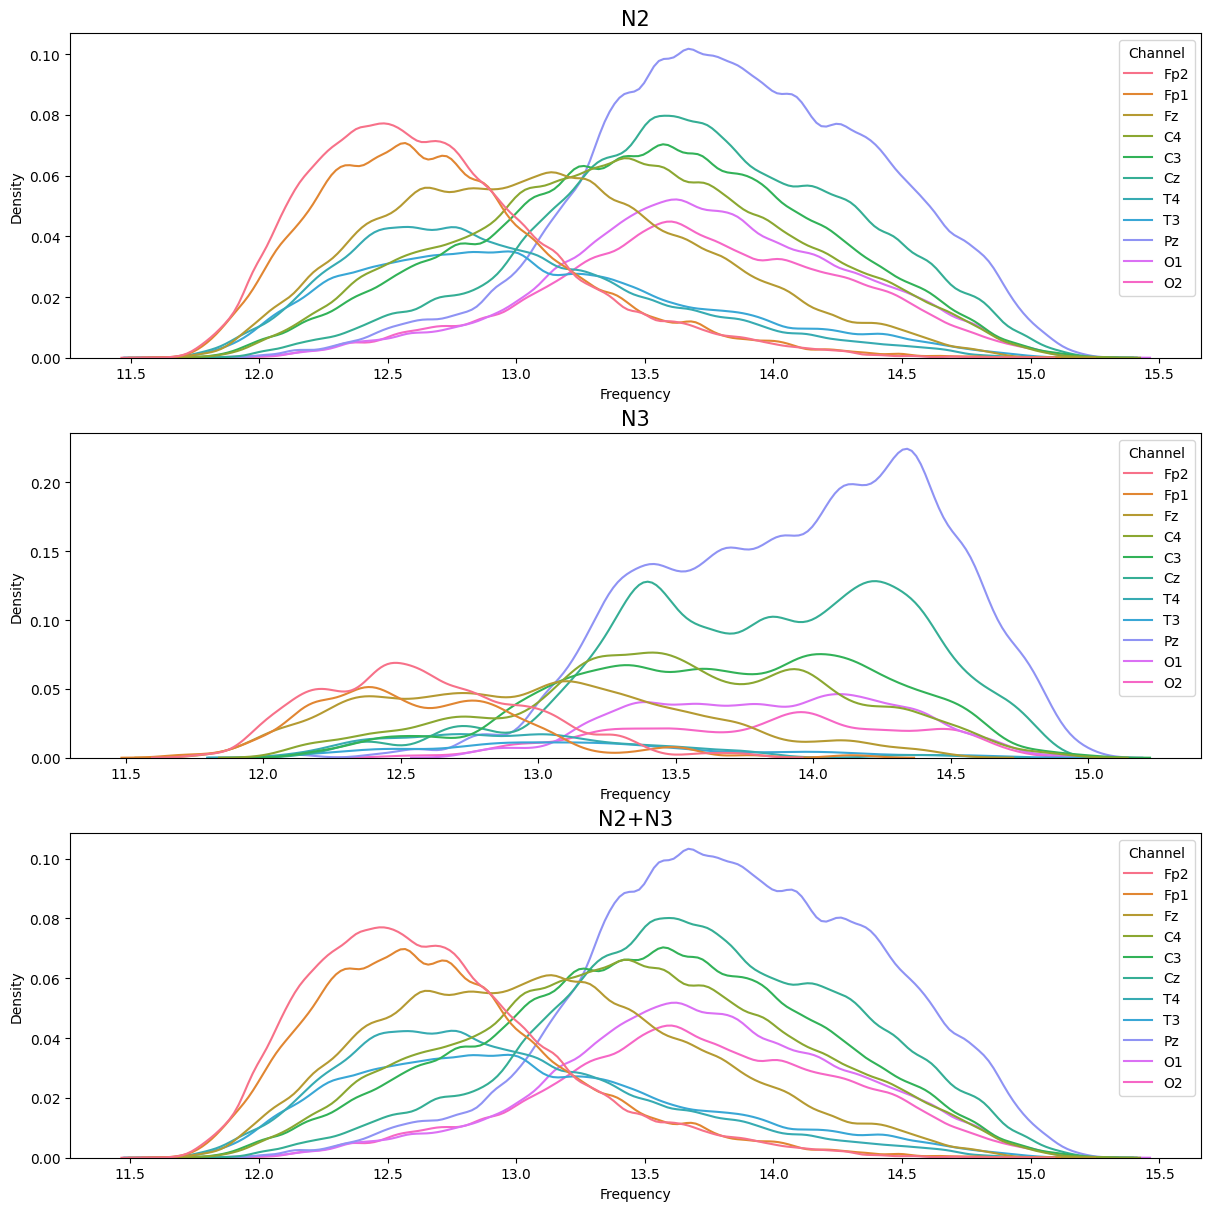

In [182]:
fig, axs = plt.subplots(nrows = 3, figsize = (12,12), constrained_layout = True)
for r, stage in enumerate(['N2','N3','N2+N3']):
    ax = axs[r]
    if stage == 'N2+N3':
        data = sps[sps['Stage_Letter'].isin(['N2','N3'])]
    else:
        data = sps[sps['Stage_Letter'] == stage]
    sns.kdeplot(data = data, x = 'Frequency' , hue = 'Channel', ax=ax, bw_adjust = 0.5)
    ax.set_title(stage, fontsize = 15)
fig.savefig(base_folder / 'results' / 'events_stats' / 'kde_pooled_N2_N3_N2N3.tif', dpi = 300, bbox_inches = 'tight')
    # ax.legend(loc = 1, fontsize = 9)

# RESP FEATURES

In [47]:
concat = []
for sub in run_keys:
    resp_sub = resp_tag_job.get(sub).to_dataframe()
    resp_sub.insert(0 , 'subject', sub)
    concat.append(resp_sub)
resp_stats = pd.concat(concat)
resp_stats = resp_stats[resp_stats['sleep_stage'].isin(['N2','N3'])]
mapper= {sub:'P{}'.format(sub.split('S')[1]) for sub in run_keys}
resp_stats['subject'] = resp_stats['subject'].map(mapper)

In [48]:
concat = []
for stage in ['N2','N3']:
    resp_stats_stage = resp_stats[resp_stats['sleep_stage'] == stage]
    m = resp_stats_stage[['cycle_duration','inspi_duration','expi_duration','cycle_ratio',]].mean().to_frame().T
    m.insert(0, 'feature', 'mean')
    m.insert(0, 'stage', stage)
    s = resp_stats_stage[['cycle_duration','inspi_duration','expi_duration','cycle_ratio',]].std().to_frame().T
    s.insert(0, 'feature', 'sd')
    s.insert(0, 'stage', stage)
    concat_stage = pd.concat([m,s])
    concat.append(concat_stage)
estimators_resp  = pd.concat(concat)

In [49]:
estimators_resp

,stage,feature,cycle_duration,inspi_duration,expi_duration,cycle_ratio
0,N2,mean,3.734737,1.564889,2.169848,0.421494
0,N2,sd,0.621678,0.275117,0.473998,0.054483
0,N3,mean,3.601571,1.520562,2.081009,0.423598
0,N3,sd,0.543692,0.263812,0.407778,0.050443


In [50]:
resp_summaries = {}
cols = ['cycle_duration','cycle_ratio','inspi_duration','expi_duration']
resp_stage_summary = pd.DataFrame(index = list(resp_stats['subject'].unique()) + ['Mean','SD'] , columns = cols)
for stage in ['N2','N3']:
    resp_stats_stage = resp_stats[resp_stats['sleep_stage'] == stage]
    summary = resp_stats_stage.groupby('subject').mean(True)[cols].reindex(mapper.values())
    resp_stage_summary.loc[mapper.values(),:] = summary
    resp_stage_summary.loc['Mean',:] = summary.mean()
    resp_stage_summary.loc['SD',:] = summary.std()
    resp_stage_summary = resp_stage_summary.astype(float).round(2)
    resp_save = resp_stage_summary.copy().reset_index().rename(columns = {'index':'Participant'})
    resp_summaries[stage] = resp_save
    resp_save.to_excel(base_folder / 'results' / 'resp_stats' / f'resp_features_{stage}.xlsx', index = False)

In [51]:
resp_summaries['N2']

,Participant,cycle_duration,cycle_ratio,inspi_duration,expi_duration
0,P1,2.81,0.45,1.26,1.55
1,P2,3.97,0.43,1.72,2.25
2,P3,3.98,0.43,1.69,2.29
3,P4,3.98,0.42,1.67,2.32
4,P5,4.13,0.43,1.77,2.35
5,P6,3.97,0.40,1.59,2.39
6,P7,3.67,0.42,1.55,2.12
7,P8,4.22,0.39,1.64,2.57
8,P9,4.79,0.37,1.78,3.01
9,P10,3.26,0.40,1.30,1.96


In [143]:
resp_summaries['N3']

,Participant,cycle_duration,cycle_ratio,inspi_duration,expi_duration
0,P1,2.761071,0.429079,1.179933,1.581138
1,P2,3.647333,0.458593,1.664272,1.983061
2,P3,3.76141,0.437357,1.640679,2.120731
3,P4,3.764034,0.424771,1.588371,2.175662
4,P5,3.776451,0.490025,1.848729,1.927721
5,P6,3.787725,0.380929,1.434448,2.353277
6,P7,3.602893,0.440178,1.584154,2.01874
7,P8,4.083648,0.390489,1.585154,2.498494
8,P9,4.484678,0.376338,1.675312,2.809366
9,P10,3.209333,0.393244,1.258861,1.950473


In [58]:
cols = ['cycle_duration','cycle_ratio','inspi_duration','expi_duration']

resp_stage_summary = pd.DataFrame(index = list(resp_stats['subject'].unique()) + ['Mean','SD'] , columns = cols)
summary = resp_stats.groupby('subject').mean(True)[cols].reindex(mapper.values())
resp_stage_summary.loc[mapper.values(),:] = summary
resp_stage_summary.loc['Mean',:] = summary.mean()
resp_stage_summary.loc['SD',:] = summary.std()
resp_stage_summary = resp_stage_summary.astype(float).round(2)
resp_save = resp_stage_summary.copy().reset_index().rename(columns = {'index':'Participant'})
resp_save.to_excel(save_folder_current / f'resp_features_N2N3.xlsx', index = False)